# Donwloading dataset and setting up data preprocessing pipeline

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

from PIL import Image
from copy import deepcopy

import os

from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn

df = pd.read_csv("/kaggle/input/chest-x-ray-lungs-segmentation/MetaData.csv")

base_path = "/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray/image/"

df["id"] = df["id"].astype(str)
df["id"] = base_path + df["id"] + ".png"

df = df[["id", "ptb"]]

EPOCHS = 20
LR = 0.1
GAMMA = 0.1
STEP = 10
IMG_SIZE = 224
OUT_SIZE = 2
BATCH = 32

class Pipeline(Dataset):
    def __init__(self, data, transform):
        super(Pipeline, self).__init__()
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data[x, 0], self.data[x, 1]
        img = Image.open(img).convert("RGB")
        img = np.array(img)
        img = self.transform(img)
        return img, label

train, val = train_test_split(df.values, random_state=42, test_size=0.2)
test, val = train_test_split(val, random_state=42, test_size=0.2)

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

train_ds = Pipeline(train, transform)
val_ds = Pipeline(val, transform)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

# ResNet configuration

In [2]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, OUT_SIZE)

class ResNet(nn.Module):
    def __init__(self, model):
        super(ResNet, self).__init__()
        self.model = model

    def forward(self, x):
        return nn.functional.softmax(self.model(x), dim=1)

model = ResNet(resnet)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 243MB/s]


# Training performance log

Epoch 1 train loss 0.020094540995772313 acc 0.7087033747779752 val loss 0.023053512491028886 acc 0.5517241379310345
Epoch 2 train loss 0.01599292528565781 acc 0.8419182948490231 val loss 0.02089366830628494 acc 0.6896551724137931
Epoch 3 train loss 0.013896195069087758 acc 0.9023090586145648 val loss 0.020047679029662032 acc 0.7241379310344828
Epoch 4 train loss 0.012266617261707042 acc 0.9413854351687388 val loss 0.016390087275669492 acc 0.8275862068965517
Epoch 5 train loss 0.011258539838011693 acc 0.9662522202486679 val loss 0.01651281426692831 acc 0.8275862068965517
Epoch 6 train loss 0.010740049302472103 acc 0.9857904085257548 val loss 0.01572045170027634 acc 0.8275862068965517
Epoch 7 train loss 0.010520584629865142 acc 0.9875666074600356 val loss 0.014455500347860929 acc 0.9310344827586207
Epoch 8 train loss 0.010411914457859833 acc 0.9893428063943162 val loss 0.014210653716120226 acc 0.896551724137931
Epoch 9 train loss 0.01036971362827091 acc 0.9911190053285968 val loss 0.0166

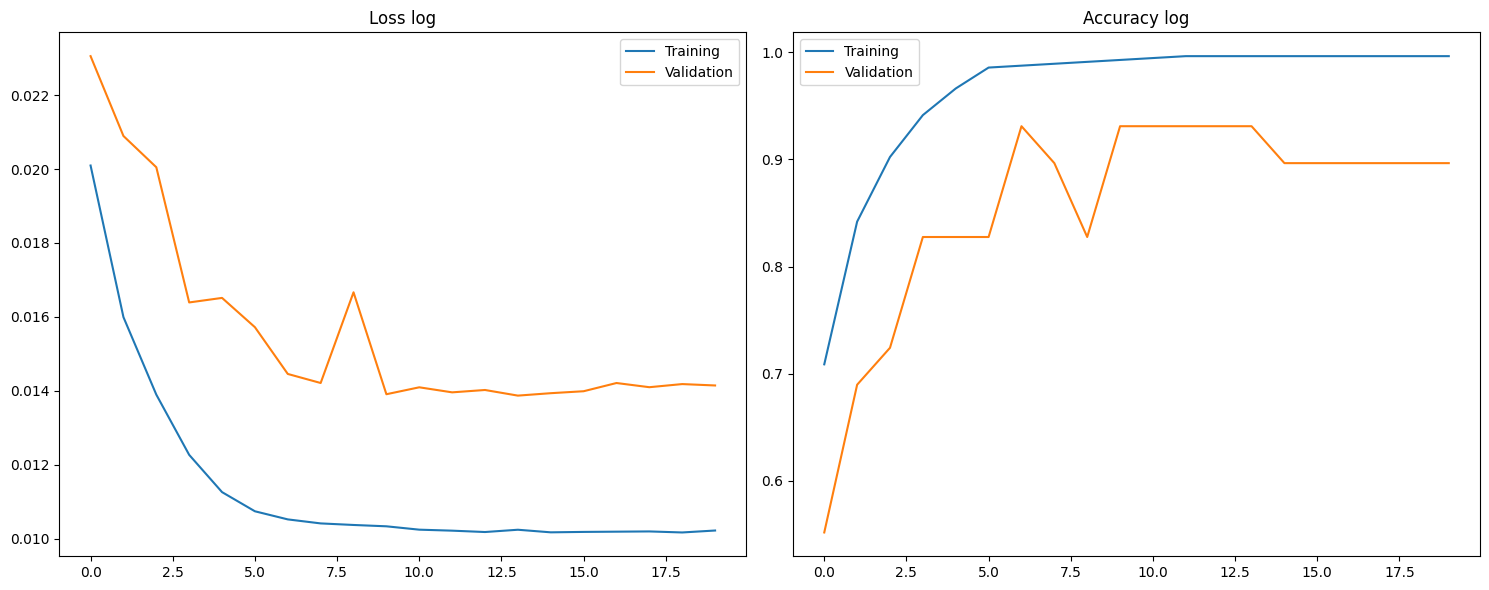

In [3]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()

    diff = 0
    acc = 0
    total = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
    train_loss += [diff/total]
    train_acc += [acc/total]
    model.eval()
    diff = 0
    acc = 0
    total = 0
    with torch.no_grad():
        for data, target in val_dl:
            
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
    val_loss += [diff/total]
    val_acc += [acc/total]
    if val_acc[-1] > best_acc:
        best_model = deepcopy(model)
        best_acc = val_acc[-1]

    print("Epoch {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1], train_acc[-1],
                                                                   val_loss[-1], val_acc[-1]))
    scheduler.step()

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validation")
axes[index].legend()
axes[index].set_title("Loss log")

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validation")
axes[index].legend()
axes[index].set_title("Accuracy log")

plt.tight_layout()
plt.show()

# Testing results

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        59
           1       0.85      0.87      0.86        53

    accuracy                           0.87       112
   macro avg       0.87      0.87      0.87       112
weighted avg       0.87      0.87      0.87       112



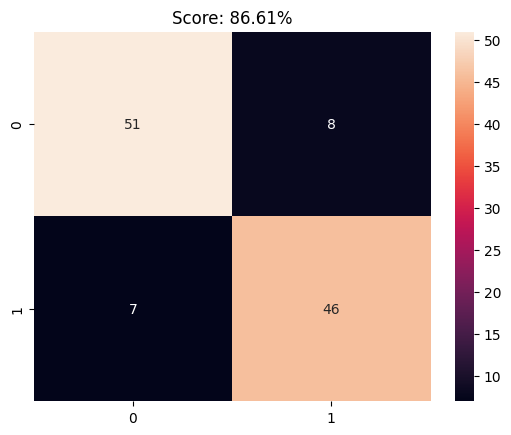

In [4]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = np.array(img)
    img = transform(img)
    img = img.view([1, 3, 224, 224])
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        out = best_model(img)
        index = out.argmax(1).item()

    return index, out[0][index].item()

truth = []
preds = []
probas = []
pred_labels = []
truth_labels = []

for i in range(test.shape[0]):
    pred, proba = predict(test[i, 0])
    preds += [pred]
    probas += [round(proba*100, 2)]
    truth += [test[i, 1]]
    pred_labels += ["Tuberculosis" if pred == 1 else "Healthy"]
    truth_labels += ["Tuberculosis" if test[i, 1] else "Healthy"]

print(classification_report(preds, truth))
sns.heatmap(confusion_matrix(preds, truth), annot=True, fmt='d')
plt.title("Score: {}%".format(round(accuracy_score(preds, truth)*100, 2)))
plt.show()

# Visual inspection

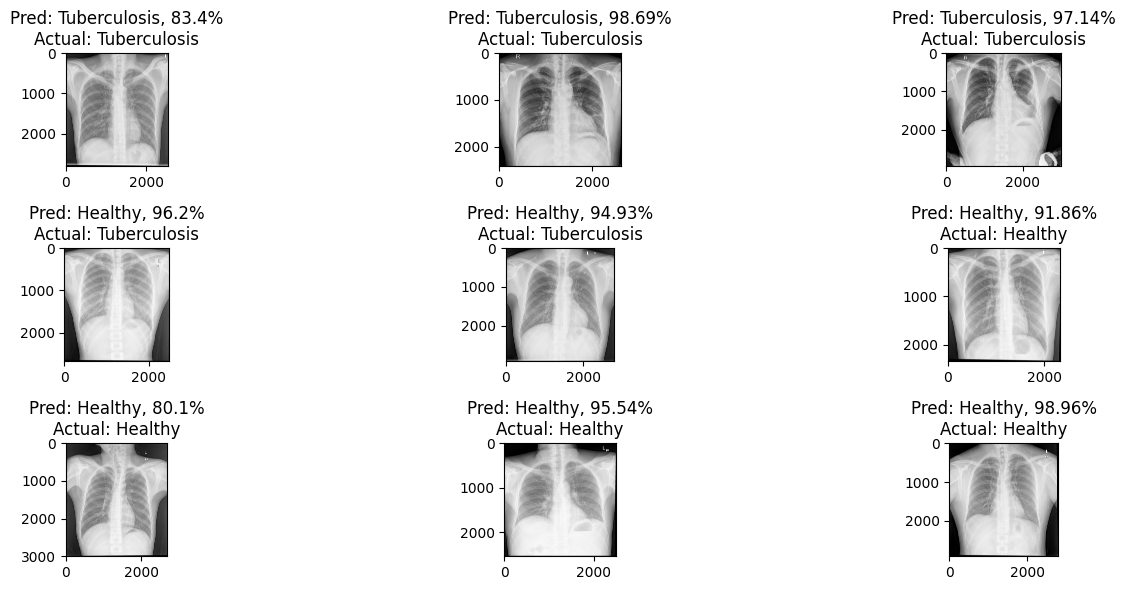

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))
index = 0

for i in range(3):
    for j in range(3):
        axes[i][j].imshow(np.array(Image.open(test[index, 0]).convert("RGB")))
        axes[i][j].set_title("Pred: {}, {}%\nActual: {}".format(pred_labels[index], probas[index], truth_labels[index]))
        index += 1
plt.tight_layout()
plt.show()